In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import re
import os.path
from scipy.optimize import curve_fit
import datetime

from matplotlib import cm as mcm
import matplotlib.mlab as mlab
import scipy.constants as const
import collections

%matplotlib inline

# %reload_ext autoreload
# %autoreload 2

# import xlsxwriter

import pyradi.ryplot as ryplot
import pyradi.ryfiles as ryfiles
import pyradi.rystare as rystare
import pyradi.ryutils as ryutils
import pyradi.rypflux as rypflux

from IPython.display import HTML
from IPython.display import Image
from IPython.display import display
from IPython.display import FileLink, FileLinks

#make pngs at stated dpi
import matplotlib as mpl
mpl.rc("savefig", dpi=600)
mpl.rc('figure', figsize=(10,8))
# %config InlineBackend.figure_format = 'svg'

pd.set_option('display.max_columns', 80)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 150)

The infrared sensor example has the following design characteristics:

| Characteristic | Value |Unit |  Motivation |
|--|--|--|--| 
|Spectral response |3.7--4.9| $\mu$m| detector specification|
|Pixel size (x and y) |12.0e-6| rad| detector specification|
|Pixel fill factor  |0.95| | detector specification|
|Detector temperature  |80|K | detector specification|
|Detector external quantum efficiency  |0.8| | detector specification|
|Detector internal quantum efficiency  |0.75| | detector specification|
|Number rows | 144 | - |  detector specification|
|Number columns | 256 | - |  detector specification|
|Detector PRNU  stddev | 0.2 | | detector specification|
|Well capacity at 1 V|3.2e6 |e | detector specification|
|Sense node voltage| 3.0 $\rightarrow$ 1.0 |V | detector specification|
|F-number | 3.2 | - | detector specification|
|Band gap 0~K | 0.235 | eV | material property|
|Varshni A | 0.68e-3 |  | material model|
|Varshni B | 500 |  | material model|
|Dark FOM | 4e-9 | nA/cm$^2$ | material model|
|Dark cm | 1 |  | material model|
|Dark FPN stddev | 0.4 |  | material model|
|Well capacitance at 1.0 V|\num{5.13e-13}| F | by calculation|
|k1 | \num{5.13e-13} | CV |by calculation|
|Gain at 1.0 V |\num{3.125e-07} | V/e| by calculation|
|Pixel IFOV (x and y) |100.0e-6| rad| design choice|
|Frame time | 0.02 | s |  design choice|
|Focal length | 0.12 | m | design choice|
|Full field angle | 0.84 | deg| focal length and detector|

Charge well (sense node} capacitance $C = nq/V$. The charge well is filled to capacity at the minimum sense node voltage $C = \num{3.2e6}\times\num{1.6e-19}/1.0= \num{0.513e-12}$~F.  Then $k_1=CV=\num{0.513e-12}\times 1=\num{0.513e-12}$.

Sense node gain is given by $V/n = q/C = \num{1.6e-19}/\num{0.513e-12}=\num{3.12e-07}$ V/e.



Well capacitance 5.12696518656e-13 F at 1.0 V
k1 is 5.12696518656e-13
Gain 3.125e-07 V/e at 1.0 V


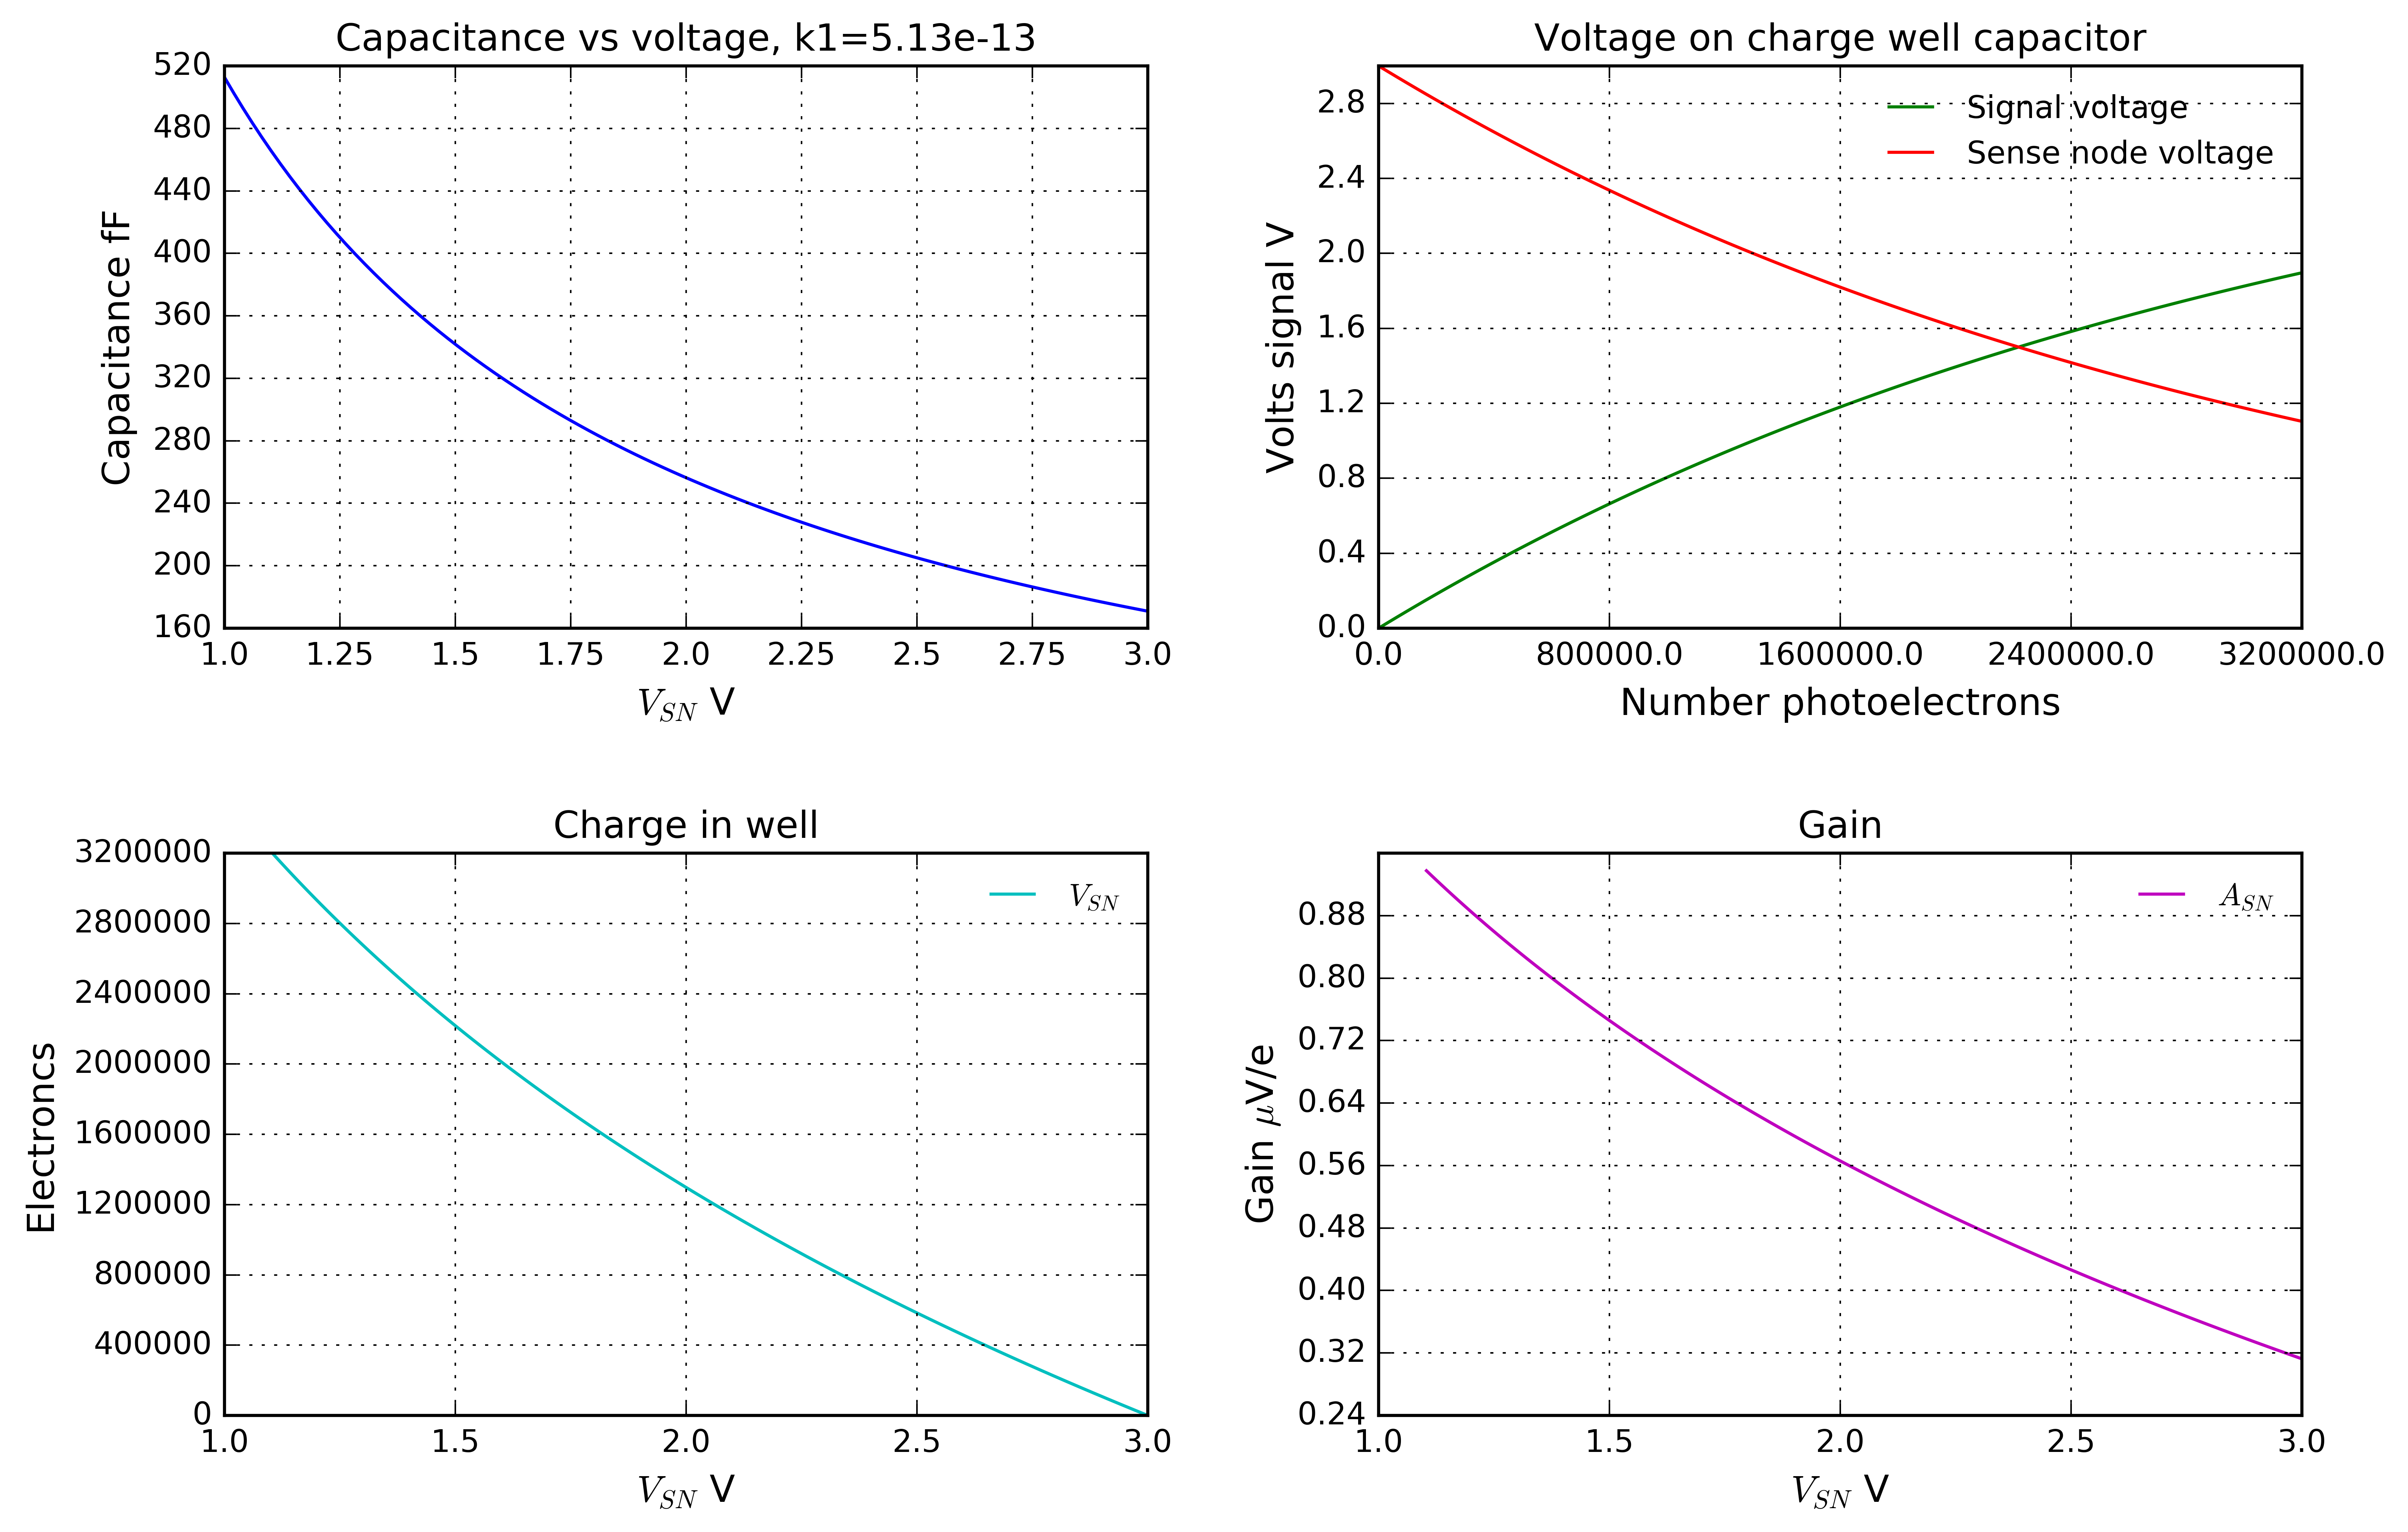

In [2]:
nwell = 3.2e6
vref = 3.0
vsnmin = 1.0
cwell = nwell * const.e / vsnmin
k1 = cwell * vsnmin
gain = const.e/cwell
print('Well capacitance {} F at {} V'.format(cwell,vsnmin))
print('k1 is {}'.format(k1))
print('Gain {} V/e at {} V'.format(gain,vsnmin))

nphelec = np.linspace(0,nwell,100)
vsnp = np.linspace(vsnmin,vref,100)
p = ryplot.Plotter(1,2,2,figsize=(12,8));
p.plot(1,vsnp,1e15*k1/vsnp,'Capacitance vs voltage, k1={:.2e}'.format(k1),
       '$V_{SN}$ V','Capacitance fF');
vsignal = vref * (1.0 - np.exp(- nphelec * const.e / (k1)))
vsn = vref * (np.exp(- nphelec * const.e / (k1)))
p.plot(2,nphelec, vsignal,'Voltage on charge well capacitor','Number photoelectrons','Volts signal V',
       label=['Signal voltage'],maxNX=5);
p.plot(2,nphelec, vsn,label=['Sense node voltage'],maxNX=5);

nelec = -(k1/const.e)*np.log(vsn/vref)
p.plot(3, vsn, nelec,'Charge in well','$V_{SN}$ V','Electroncs',label=['$V_{SN}$'],maxNX=5);
p.plot(4, vsn, 1e6*const.e*vsnp/k1,'Gain','$V_{SN}$ V','Gain $\mu$V/e',label=['$A_{SN}$'],maxNX=5);


In [3]:
L=1 # w/(m2sr)
dx = 25e-6
areaD = dx*dx
f = 0.15
fno = 1.
omegafno = np.pi/(2.*fno)**2 # sr
phiw = L * omegafno * areaD  # watt
lam = 4.5e-6
phiq = phiw *  lam/ (const.c * const.h)
Edet = phiq / areaD

print('c = {:3e}'.format(const.c))
print('h = {:3e}'.format(const.h))
print('lam = {:3e}'.format(lam))
print('lmhc = {:3e}'.format(4.5e-6 / (const.c * const.h)))
print('omegafno = {:3e}'.format(omegafno))
print('phiw = {:3e} W'.format(phiw))
print('phiq = {:3e} q/s'.format(phiq))
print('Edet = {:3e} q/sm2'.format(Edet))



c = 2.997925e+08
h = 6.626070e-34
lam = 4.500000e-06
lmhc = 2.265352e+19
omegafno = 7.853982e-01
phiw = 4.908739e-10 W
phiq = 1.112002e+10 q/s
Edet = 1.779204e+19 q/sm2


In [4]:
4.5e-6 / (3e8*6.6e-34)

2.272727272727273e+19